In [1]:
import petsc4py
from petsc4py import PETSc
import pymgmc
from tqdm.notebook import tqdm

import numpy as np
import emcee
from matplotlib import pyplot as plt

import sys

In [2]:
OptDB = PETSc.Options()

### Assemble matrix

In [3]:
size     = 129
kappainv = 10

kappa2 = 1. / kappainv**2
kappa4 = kappa2 ** 2
h = 1. / (size - 1)
h2inv = 1. / h**2
h4inv = h2inv ** 2

da = PETSc.DMDA().create([size, size], stencil_type=PETSc.DMDA.StencilType.BOX, stencil_width=2, comm=PETSc.COMM_WORLD)
A  = da.createMat()

(istart, iend), (jstart, jend) = da.getRanges()

In [4]:
row = PETSc.Mat.Stencil()
col = PETSc.Mat.Stencil()

for j in range(jstart, jend):
    for i in range(istart, iend):
        row.j = j
        row.i = i

        if j-2 >= 0:
            col.j = j-2
            col.i = i
            A.setValueStencil(row, col, h4inv)

        if (j != 0) and (i != 0):
            col.j = j-1
            col.i = i-1
            A.setValueStencil(row, col, 2 * h4inv)

        if j != 0:
            col.j = j-1
            col.i = i
            A.setValueStencil(row, col, -2*kappa2 * h2inv - 8*h4inv)

        if (j != 0) and (i != size-1):
            col.j = j-1
            col.i = i+1
            A.setValueStencil(row, col, 2*h4inv)

        if i-2 >= 0:
            col.j = j
            col.i = i-2
            A.setValueStencil(row, col, h4inv)

        if i != 0:
            col.j = j
            col.i = i-1
            A.setValueStencil(row, col, -2 * kappa2 * h2inv - 8 * h4inv)

        col.j = j
        col.i = i
        A.setValueStencil(row, col, kappa4 + 2 * kappa2 * 4 * h2inv * h2inv + 20 * h4inv)

        if i != size-1:
            col.j = j
            col.i = i+1
            A.setValueStencil(row, col, -2 * kappa2 * h2inv - 8 * h4inv)

        if i+2 < size:
            col.j = j
            col.i = i+2
            A.setValueStencil(row, col, h4inv)

        if (j != size-1) and (i != 0):
            col.j = j+1
            col.i = i-1
            A.setValueStencil(row, col, 2*h4inv)

        if j != size - 1:
            col.j = j + 1
            col.i = i
            A.setValueStencil(row, col, -2 * kappa2 * h2inv - 8 * h4inv)

        if (j != size-1) and (i != size-1):
            col.j = j + 1
            col.i = i + 1
            A.setValueStencil(row, col, 2 * h4inv)

        if j + 2 < size:
            col.j = j + 2
            col.i = i
            A.setValueStencil(row, col, h4inv)

A.assemblyBegin()
A.assemblyEnd()

### Setup sampler (using PETSc's PCMG geometric or PCGAMG algebraic preconditioner)

In [5]:
n_samples = 500
n_burnin  = 100

def make_sampler(algebraic, ksp):
    ksp.setType(PETSc.KSP.Type.RICHARDSON)
    ksp.setOperators(A,A)
    ksp.setInitialGuessNonzero(True)
    ksp.setNormType(PETSc.KSP.NormType.NONE)
    
    pc = ksp.getPC()
    
    if algebraic:
        pc.setType(PETSc.PC.Type.GAMG)
        ksp.setUp()
    else:
        ksp.setDM(da)
        ksp.setDMActive(False)
        pc.setType(PETSc.PC.Type.MG)
        OptDB.setValue("-pc_mg_galerkin", "both")
        OptDB.setValue("-pc_mg_type", "full")
        pc.setFromOptions()
    
        pc.setMGLevels(4)
    
    # Configure random smoothers
    print(f"Using {pc.getMGLevels()} levels") 
    for i in range(0,  pc.getMGLevels()):
        kspsmooth = pc.getMGSmoother(i)
        kspsmooth.setType(PETSc.KSP.Type.RICHARDSON)
        kspsmooth.setTolerances(0,0,0,2)
    
        pcsmooth = kspsmooth.getPC()
        pcsmooth.setType("gibbs")
    
    # Setup coarse level Cholesky sampler
    # kspsmooth = pc.getMGSmoother(0)
    # kspsmooth.setType(PETSc.KSP.Type.PREONLY)
    # pcsmooth = kspsmooth.getPC()
    # pcsmooth.setType("cholsampler")
    
    if not algebraic:
        ksp.setUp()

ksp_geo = PETSc.KSP().create(comm=PETSc.COMM_WORLD)
make_sampler(False, ksp_geo)

ksp_alg = PETSc.KSP().create(comm=PETSc.COMM_WORLD)
make_sampler(True, ksp_alg)

Using 4 levels
Using 4 levels


### Set up function that is called for every sample

In [6]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        return self.update(b * bsize - self.n)  # also sets self.n = b * bsize

geopbar = tqdm(display=False)
algpbar = tqdm(display=False)
def sample_callback(ksp, it, r, samples, pbar):
    sample = ksp.getSolution()
    samples[it] = sample.norm()

    if it == 0:
        _,_,_,maxits = ksp.getTolerances()
        pbar.reset(maxits)
    pbar.update()
    
    # Since this is not actually a convergence test, just return that we're still iterating
    return PETSc.KSP.ConvergedReason.ITERATING

samples_geo = np.zeros((max(n_samples, n_burnin),))
samples_alg = np.zeros((max(n_samples, n_burnin),))

ksp_geo.setConvergenceTest(sample_callback, kargs={"samples": samples_geo, "pbar": geopbar})
ksp_alg.setConvergenceTest(sample_callback, kargs={"samples": samples_alg, "pbar": algpbar})

### Sample

<>:29: SyntaxWarning: invalid escape sequence '\k'
<>:29: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_359908/1546585660.py:29: SyntaxWarning: invalid escape sequence '\k'
  plt.title(f"Lagged autorcorrelation function (Grid {size}x{size}, $\kappa^{{-1}} = {kappainv}$)")


0it [00:00, ?it/s]

0it [00:00, ?it/s]

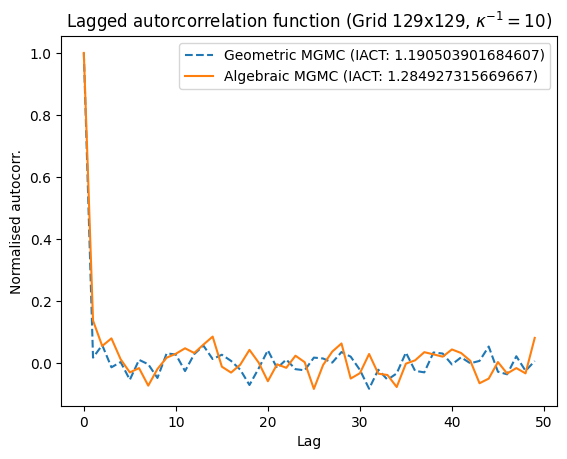

In [7]:
display(geopbar.container)
display(algpbar.container)

x,b = A.createVecs()

# Run burnin
ksp_geo.setTolerances(0,0,0,n_burnin)
ksp_geo.solve(b, x)

ksp_alg.setTolerances(0,0,0,n_burnin)
ksp_alg.solve(b, x)

# Compute actual samples
ksp_geo.setTolerances(0,0,0,n_samples)
ksp_geo.solve(b, x)
autocorr_geo = emcee.autocorr.function_1d(samples_geo[:n_samples])

ksp_alg.setTolerances(0,0,0,n_samples)
ksp_alg.solve(b, x)
autocorr_alg = emcee.autocorr.function_1d(samples_alg[:n_samples])

plot_range = 50
plt.plot(autocorr_geo[:plot_range], linestyle='--',
         label=f"Geometric MGMC (IACT: {emcee.autocorr.integrated_time(autocorr_geo, quiet=True)[0]})")
plt.plot(autocorr_alg[:plot_range], linestyle='-',
         label=f"Algebraic MGMC (IACT: {emcee.autocorr.integrated_time(autocorr_alg, quiet=True)[0]})")

plt.legend()
plt.title(f"Lagged autorcorrelation function (Grid {size}x{size}, $\kappa^{{-1}} = {kappainv}$)")
plt.xlabel("Lag")
plt.ylabel("Normalised autocorr.")
plt.show()

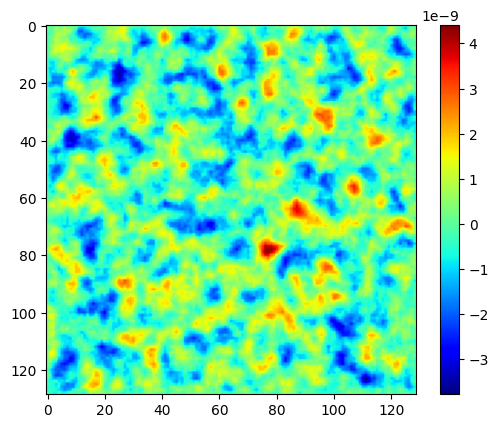

In [8]:
ksp_geo.setTolerances(0,0,0,1)
ksp_geo.solve(b, x)

sample = x.array
sample = sample.reshape((size,size))
plt.imshow(sample, cmap='jet')
plt.colorbar()
plt.show()